# Data for Marit
This notebook documents how the data is created for Marit's Bachelor thesis. It needs to be run on JASMIN's jupyter hub (https://notebooks.jasmin.ac.uk). 

In [1]:
import os
import sys
import numpy as np
import xesmf as xe
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
sys.path.append('..')
%load_ext autoreload
%autoreload 2

/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
from iterate import IterateECE

In [3]:
times   = pd.date_range(start='1950-01-01', end='2101-01-01', freq='M')# np.arange(1950,2101,1/12)
srcs    = ['EC-Earth3P', 'EC-Earth3P-HR']
exps    = ['control', 'hist+future']
exps2   = ['control-1950','highres-future','hist-1950']
members = [f'r{i}i1p2f1' for i in range(1,4)]

## global mean `zos`

In [4]:
%%time
# checking if gloabl-mean zos is 0
for da_files, src, exp, mem in IterateECE(var='zos', cat='jasmin-nc', only_filenames=True):  # , source='EC-Earth3P-HR'
    print(len(da_files))
    if src=='EC-Earth3P-HR':  areacello = xr.open_dataset('../../data/T511-ORCA025/areacello.nc').areacello
    elif src=='EC-Earth3P':   areacello = xr.open_dataset('../../data/T255-ORCA1/areacello.nc').areacello
    print(src, exp, mem)
    fn = f'../../data/Marit/gmzos_{src}_{exp}_{mem}.nc'
    if os.path.exists(fn)==False:
        if len(da_files)<100:
            da = xr.open_mfdataset(da_files).zos
            da_ = ((da*areacello).sum(['j','i'])/areacello.sum())
            da_.to_netcdf(fn)
        else:
            # kernel crashes when too many HR files are loaded
            for i in range(2):
                if i==0:  da_files_ = da_files[:50]
                else:     da_files_ = da_files[50:]
                da = xr.open_mfdataset(da_files_).zos
                da_ = ((da*areacello).sum(['j','i'])/areacello.sum())
                fn = f'../../data/Marit/gmzos_{src}_{exp}_{i}_{mem}.nc'
                print(fn)
                da_.to_netcdf(fn)
                if i==1:
                    mds = xr.open_mfdataset('../../data/Marit/gmzos_EC-Earth3P-HR_control-1950_*_{mem}.nc')
                    mds.to_netcdf('../../data/Marit/gmzos_EC-Earth3P-HR_control-1950_{mem}.nc')

jasmin-nc
<jasmin_nc_highresmip catalog with 288 dataset(s) from 8066 asset(s)>
There are 18 datasets
100
EC-Earth3P control-1950 r1i1p2f1
100
EC-Earth3P control-1950 r2i1p2f1
112
EC-Earth3P control-1950 r3i1p2f1
36
EC-Earth3P highres-future r1i1p2f1
36
EC-Earth3P highres-future r2i1p2f1
85
EC-Earth3P highres-future r3i1p2f1
65
EC-Earth3P hist-1950 r1i1p2f1
65
EC-Earth3P hist-1950 r2i1p2f1
65
EC-Earth3P hist-1950 r3i1p2f1
100
EC-Earth3P-HR control-1950 r1i1p2f1
101
EC-Earth3P-HR control-1950 r2i1p2f1
150
EC-Earth3P-HR control-1950 r3i1p2f1
36
EC-Earth3P-HR highres-future r1i1p2f1
36
EC-Earth3P-HR highres-future r2i1p2f1
85
EC-Earth3P-HR highres-future r3i1p2f1
65
EC-Earth3P-HR hist-1950 r1i1p2f1
65
EC-Earth3P-HR hist-1950 r2i1p2f1
65
EC-Earth3P-HR hist-1950 r3i1p2f1
CPU times: user 400 ms, sys: 47.4 ms, total: 448 ms
Wall time: 1.15 s


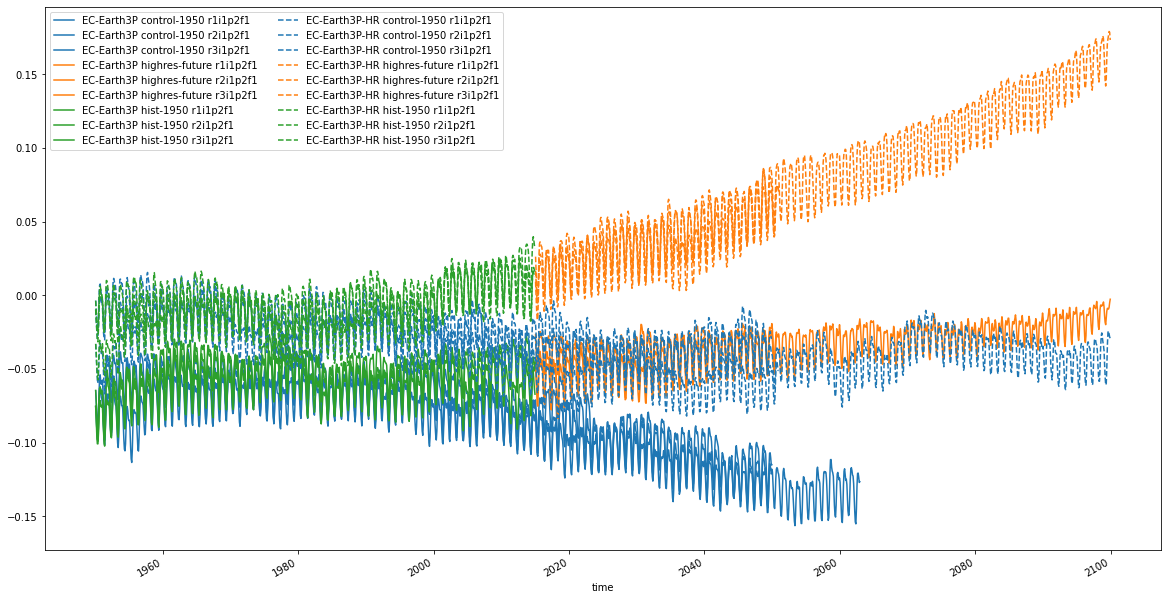

In [5]:
plt.figure(figsize=(20,10))
for i, src in enumerate(srcs):
    for j, exp in enumerate(exps2):
        for k, mem in enumerate(members):
            fn = f'../../data/Marit/gmzos_{src}_{exp}_{mem}.nc'
            da = xr.open_dataarray(fn)
            da.plot(c=f'C{j}', ls=['-','--'][i], label=f'{src} {exp} {mem}')
plt.legend(ncol=2)
plt.savefig('../../results/zos/gmzos.png')

In [6]:
# new dataarray to hold global mean zos
# (1) with combined hist+future experiment name; like den Helder time series
# (2) with three original experiment names; like zos/uas/vas maps
data = np.empty((len(times), len(srcs), len(exps), len(members)))
data[:,:,:,:] = np.nan
da_new1 = xr.DataArray(dims=['time', 'src', 'exp', 'member'],
                       coords={'time':times, 'src':srcs, 'exp':exps, 'member':members},
                       data=data,
                      )

data = np.empty((len(times), len(exps2), len(members)))
data[:,:,:] = np.nan
da_new2 = xr.DataArray(dims=['time', 'exp', 'member'],
                          coords={'time':times, 'exp':exps2, 'member':members},
                          data=data,
                         )

fn2 = f'../../data/Marit/gmzos_2exps.nc'
for i, src in enumerate(srcs):
    fn3 = f'../../data/Marit/gmzos_3exps_{src}.nc'
    for k, mem in enumerate(members):
        for j, exp in enumerate(exps2):
            fn = f'../../data/Marit/gmzos_{src}_{exp}_{mem}.nc'
            da = xr.open_dataarray(fn)
            if exp=='control-1950':
                e, ts = 0, 0
            elif exp=='hist-1950':
                e, ts = 1, 0
            elif exp=='highres-future':
                e, ts = 1, (2015-1950)*12
            te = ts+len(da.time)
            
            # case (1)
            if src=='EC-Earth3P':
                s = 0
            elif src=='EC-Earth3P-HR':
                s = 1
            m = int(mem[1])-1
            print(ts, te, len(da.time), e, m)
            da_new1[ts:te, s, e,m] = da.values
            
            # case (2)
            if exp=='control-1950':
                e, ts = 0, 0
            elif exp=='hist-1950':
                e, ts = 1, 0
            elif exp=='highres-future':
                e, ts = 1, (2015-1950)*12
            
            m = int(mem[1])-1
            print(ts, te, len(da.time), e, m)
            da_new2[ts:te,e,m] = da.values
    da_new2.to_netcdf(fn3)
da_new1.to_netcdf(fn2)

0 1200 1200 0 0
0 1200 1200 0 0
780 1212 432 1 0
780 1212 432 1 0
0 780 780 1 0
0 780 780 1 0
0 1200 1200 0 1
0 1200 1200 0 1
780 1212 432 1 1
780 1212 432 1 1
0 780 780 1 1
0 780 780 1 1
0 1344 1344 0 2
0 1344 1344 0 2
780 1800 1020 1 2
780 1800 1020 1 2
0 780 780 1 2
0 780 780 1 2
0 1200 1200 0 0
0 1200 1200 0 0
780 1212 432 1 0
780 1212 432 1 0
0 780 780 1 0
0 780 780 1 0
0 1212 1212 0 1
0 1212 1212 0 1
780 1212 432 1 1
780 1212 432 1 1
0 780 780 1 1
0 780 780 1 1
0 1800 1800 0 2
0 1800 1800 0 2
780 1800 1020 1 2
780 1800 1020 1 2
0 780 780 1 2
0 780 780 1 2


## select `zos` time series at Den Helder for EC-Earth3P(-HR)

In [7]:
indices = {}
for i, src in enumerate(['EC-Earth3P','EC-Earth3P-HR']):
    fn = f'../../data/{["T255-ORCA1","T511-ORCA025"][i]}/sftof.nc'
    da = xr.open_dataset(fn)['sftof']
    lat_DH, lon_DH = 52.9563, 4.7608  # coordinates Den Helder
    # based on https://stackoverflow.com/questions/58758480/\
    # xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(da.latitude-lat_DH)
    abslon = np.abs(da.longitude-lon_DH)
    c = np.maximum(abslon, abslat)
#     print(c.shape)
    ([yloc],[xloc]) = np.where(c == np.min(c))
#     print(xloc,yloc, da.sel({'i':xloc,'j':yloc}))
    indices[src] = (xloc,yloc)
    
print(indices)

{'EC-Earth3P': (290, 225), 'EC-Earth3P-HR': (1160, 782)}


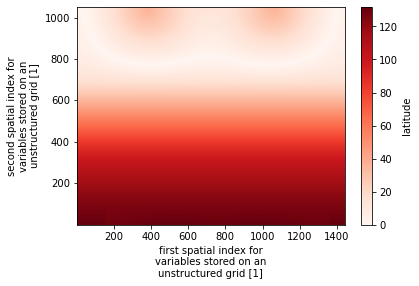

In [8]:
abslat.plot(vmin=0, cmap='Reds')

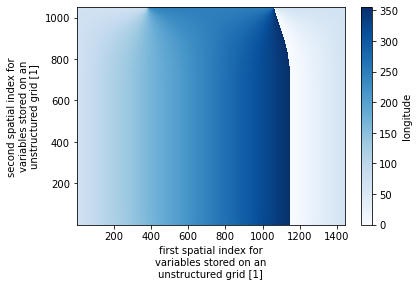

In [9]:
abslon.plot(vmin=0, cmap='Blues')

In [10]:
# combining data into single DataArray
data    = np.empty((len(times), len(srcs), len(exps), len(members)))
data[:,:,:,:] = np.nan
da_new = xr.DataArray(dims=['time', 'src', 'exp', 'member'],
                      coords={'time':times, 'src':srcs, 'exp':exps, 'member':members},
                      data=data,
                     )

In [11]:
%%time
# 13min 51s

def select_location(ds):
    """preprocessing function to select indices and zos variable"""
    if len(ds.i)==1442:
        src = 'EC-Earth3P-HR'
    else:
        src = 'EC-Earth3P'
    (xloc,yloc) = indices[src]
    return ds.sel({'i':xloc,'j':yloc})
    
fn = '../../data/Marit/zos_DenHelder.nc'    
if os.path.exists(fn)==False:
    for da_, src, exp, mem in IterateECE(var='zos', cat='jasmin-nc', only_filenames=True):  # , source='EC-Earth3P-HR'
        print(src, exp, mem)
        da = xr.open_mfdataset(da_, preprocess=select_location).zos
        if exp=='control-1950':
            e, ts = 0, 0
        elif exp=='hist-1950':
            e, ts = 1, 0
        elif exp=='highres-future':
            e, ts = 1, (2015-1950)*12
        if src=='EC-Earth3P':
            s = 0
        elif src=='EC-Earth3P-HR':
            s = 1
        te = ts+len(da.time)
        m = int(mem[1])-1
        print(ts, te, len(da.time), e, m)
        da_new[ts:te, s, e,m] = da.values

    da_new.to_netcdf(fn)

CPU times: user 35 µs, sys: 15 µs, total: 50 µs
Wall time: 55.3 µs


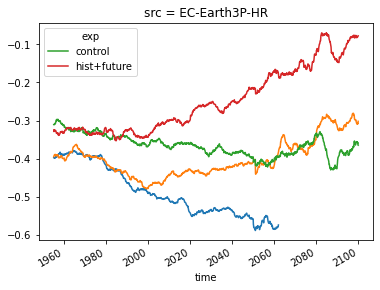

In [12]:
da_new = xr.open_dataarray(fn)
for src in srcs:
    da_new.sel(src=src).rolling(time=60).mean().mean('member').plot.line(x='time', label=f'{src} {exp}')

## extended North Sea maps of `zos` and `u`/`v` surface winds

### dynamic sea level `zos`

In [13]:
%%time
# ca. 10-12 mins
def select_NorthSea(da):
    return da.sel(ns)

var = 'zos'

for src in srcs:
    # selecting the North Sea only
    if src=='EC-Earth3P-HR':
        ns = {'i':slice(1101,1175),'j':slice(721,860)}
        res = 'HR'
    elif src=='EC-Earth3P':
        ns = {'i':slice( 275, 294),'j':slice(210,244)}
        res = 'SR'
    i_s = np.arange(ns['i'].start, ns['i'].stop+1)
    j_s = np.arange(ns['j'].start, ns['j'].stop+1)
    
    fn = f'../../data/Marit/{var}_NorthSea_{res}.nc'
    if os.path.exists(fn)==False:
        # combining data into single DataArray
        data = np.empty((len(times), len(j_s), len(i_s), len(exps), len(members))).astype('float32')
        data[:,:,:,:,:] = np.nan
        da_new = xr.DataArray(dims=['time', 'j', 'i', 'exp', 'member'],
                              coords={'time':times, 'j':j_s,'i':i_s, 'exp':exps, 'member':members},
                              data=data,
                             )

        for da_, src, exp, mem in IterateECE(var=var, source=src, cat='jasmin-nc', only_filenames=True):  # 'EC-Earth3P-HR'
            da = xr.open_mfdataset(da_, preprocess=select_NorthSea).zos
            if exp=='control-1950':
                e, ts = 0, 0
            elif exp=='hist-1950':
                e, ts = 1, 0
            elif exp=='highres-future':
                e, ts = 1, (2015-1950)*12
            te = ts+len(da.time)
            m = int(mem[1])-1
            print(ts, te, len(da.time), e, m)
            da_new[ts:te,:,:,e,m] = da.values
        da_new = da_new.assign_coords({'latitude':da.latitude, 'longitude':da.longitude})
        da_new.astype('float32').to_netcdf(fn)
        print(src, exp, mem)

CPU times: user 98 µs, sys: 42 µs, total: 140 µs
Wall time: 88.9 µs


/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


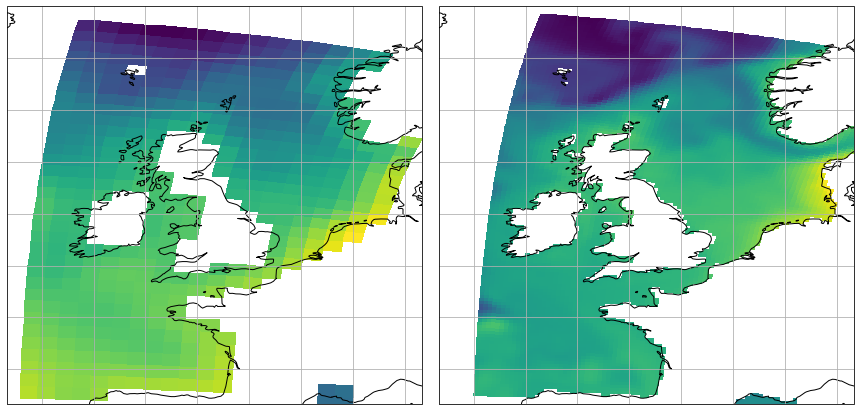

In [15]:
f = plt.figure(figsize=(12,8))
for i, res in enumerate(['SR', 'HR']):
    ax = f.add_axes([.01+i*.5,.01,.48,.98], projection=ccrs.PlateCarree())
    ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
    da = xr.open_dataarray(f'../../data/Marit/zos_NorthSea_{res}.nc')
    ax.pcolormesh(da.longitude, da.latitude, 
                  da.isel({'time':0, 'exp':0, 'member':0}),
                  transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()

In [16]:
%%time
# ca. 10-12 mins
def select_NorthSea(da):
    return da.sel(ns)

for src in srcs:
    # selecting the North Sea only
    if src=='EC-Earth3P-HR':
        ns = {'i':slice(1101,1175),'j':slice(721,860)}
        res = 'HR'
    elif src=='EC-Earth3P':
        ns = {'i':slice( 275, 294),'j':slice(210,244)}
        res = 'SR'
    i_s = np.arange(ns['i'].start, ns['i'].stop+1)
    j_s = np.arange(ns['j'].start, ns['j'].stop+1)

    fn = f'../../data/Marit/{var}_NorthSea_{res}.nc'
    if os.path.exists(fn)==False:
        # combining data into single DataArray
        data = np.empty((len(times), len(j_s), len(i_s), len(exps), len(members))).astype('float32')
        data[:,:,:,:,:] = np.nan
        da_new = xr.DataArray(dims=['time', 'j', 'i', 'exp', 'member'],
                              coords={'time':times, 'j':j_s,'i':i_s, 'exp':exps, 'member':members},
                              data=data,
                             )

        for da_, src, exp, mem in IterateECE(var=var, source=src, cat='jasmin-nc', only_filenames=True):  # 'EC-Earth3P-HR'
            da = xr.open_mfdataset(da_, preprocess=select_NorthSea).zos
            if exp=='control-1950':
                e, ts = 0, 0
            elif exp=='hist-1950':
                e, ts = 1, 0
            elif exp=='highres-future':
                e, ts = 1, (2015-1950)*12
            te = ts+len(da.time)
            m = int(mem[1])-1
            print(ts, te, len(da.time), e, m)
            da_new[ts:te,:,:,e,m] = da.values

        da_new = da_new.assign_coords({'latitude':da.latitude, 'longitude':da.longitude})
        da_new.astype('float32').to_netcdf(fn)
        print(src, exp, mem)

CPU times: user 205 µs, sys: 39 µs, total: 244 µs
Wall time: 177 µs


### surface winds `u`/`v`

In [18]:
%%time
# ca. 10-12 mins
def sel_ifs_NS(da):
    """ select North Sea in IFS rectangular data """
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).roll(lon=int(len(da.lon)/2))
    return da.sel({'lat':slice(43,66), 'lon':slice(-14,10)})


for var in ['uas','vas']:
    for j, src in enumerate(srcs):
        fn = f'../../data/Marit/{var}_NorthSea_{["SR","HR"][j]}.nc'
        if os.path.exists(fn)==False:
            for i, (da_, src, exp, mem) in enumerate(IterateECE(var=var, source=src, cat='jasmin-nc', only_filenames=True)):  # 'EC-Earth3P-HR'
                da = xr.open_mfdataset(da_, preprocess=sel_ifs_NS)[var]
                if i==0:
                    # combining data into single DataArray
                    data = np.empty((len(times), len(da.lat), len(da.lon), len(exps), len(members))).astype('float32')
                    data[:,:,:,:,:] = np.nan
                    da_new = xr.DataArray(dims=['time', 'lat', 'lon', 'exp', 'member'],
                                  coords={'time':times, 'lat':da.lat, 'lon':da.lon, 'exp':exps, 'member':members},
                                  data=data,
                                 )

                if exp=='control-1950':
                    e, ts = 0, 0
                elif exp=='hist-1950':
                    e, ts = 1, 0
                elif exp=='highres-future':
                    e, ts = 1, (2015-1950)*12
                te = ts+len(da.time)
                m = int(mem[1])-1
                print(ts, te, len(da.time), e, m)
                da_new[ts:te,:,:,e,m] = da.values
            da_new.astype('float32').to_netcdf(fn)
            print(src, exp, mem)

CPU times: user 220 µs, sys: 100 µs, total: 320 µs
Wall time: 226 µs


### surface winds `u`/`v`

In [19]:
for res in ['HR','SR']:
    da = xr.open_dataarray(f'uas_NorthSea_{res}.nc')
    print(da)

<xarray.DataArray (time: 1812, lat: 66, lon: 68, exp: 2, member: 3)>
[48793536 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * lat      (lat) float32 43.02 43.38 43.73 44.08 ... 64.8 65.15 65.5 65.85
  * lon      (lon) float32 -13.71 -13.36 -13.01 -12.66 ... 9.141 9.492 9.844
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'
<xarray.DataArray (time: 1812, lat: 33, lon: 34, exp: 2, member: 3)>
[12198384 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * lat      (lat) float32 43.16 43.86 44.56 45.26 ... 63.51 64.21 64.91 65.61
  * lon      (lon) float32 -13.36 -12.66 -11.95 -11.25 ... 8.438 9.141 9.844
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'


## regridding North Sea SR to HR data

## Regridding

### trying it out with different algorithms for zos

In [20]:
dh = xr.open_dataarray(f'../../data/Marit/zos_NorthSea_HR.nc').sel({'exp':'hist+future', 'member':'r2i1p2f1'}).mean('time')
ds = xr.open_dataarray(f'../../data/Marit/zos_NorthSea_SR.nc').sel({'exp':'hist+future', 'member':'r2i1p2f1'}).mean('time')

In [21]:
# xESMF expects specific names
dh = dh.rename({'latitude':'lat','longitude':'lon'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})

In [22]:
# regridder = xe.Regridder(ds, dh, "bilinear")  # "bilinear" is the regridding  algorithm
regridder = xe.Regridder(ds, dh, "nearest_s2d")
# regridder = xe.Regridder(ds, dh, "nearest_d2s")  # this doesn't work
# regridder = xe.Regridder(ds, dh, "conservative")
ds_regridded = regridder(ds)

/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


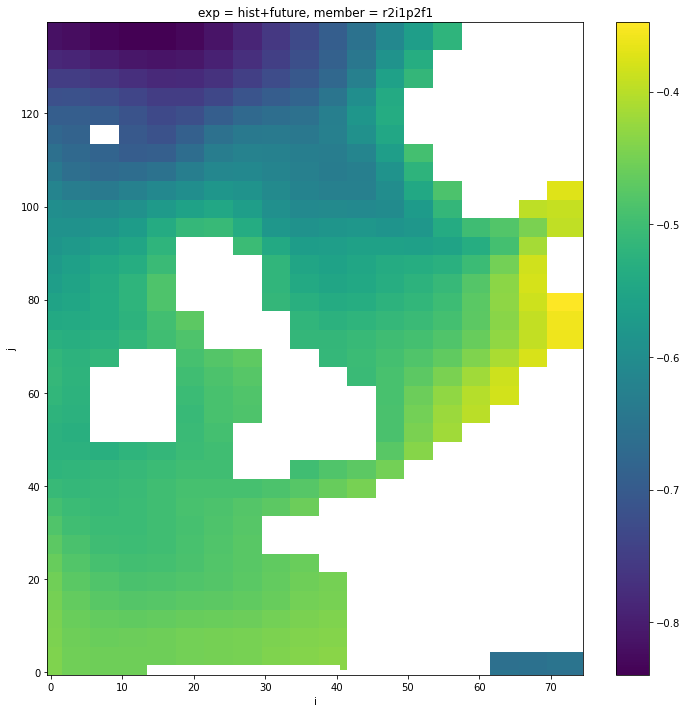

In [23]:
ds_regridded.plot(figsize=(12,12))

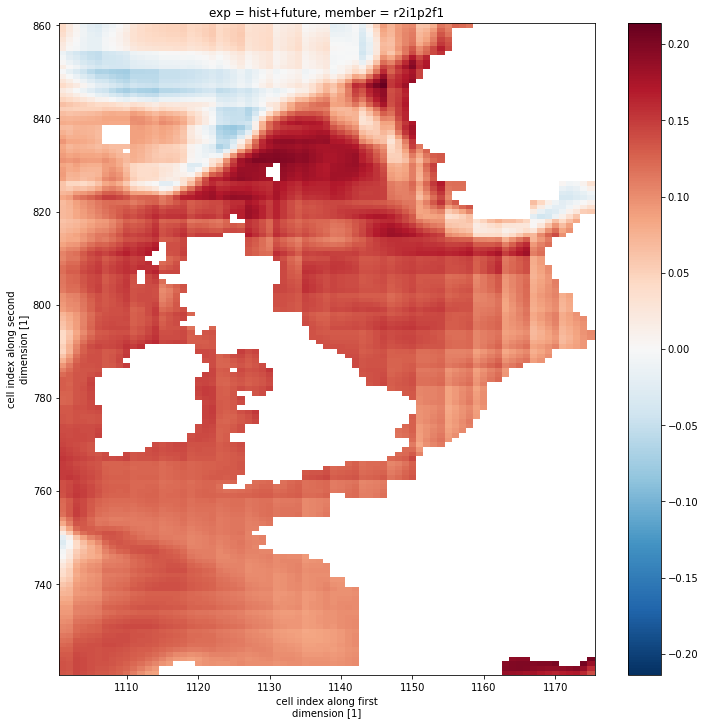

In [24]:
(dh-ds_regridded).plot(figsize=(12,12))

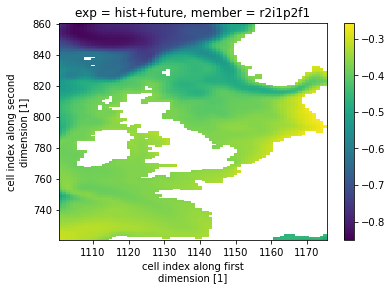

In [25]:
dh.plot()

### regrid whole `zos` dataset

In [26]:
ds = xr.open_dataarray(f'../../data/Marit/zos_NorthSea_SR.nc')

In [27]:
ds_regridded = regridder(ds)

/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [28]:
ds_regridded

<xarray.DataArray (time: 1812, exp: 2, member: 3, j: 140, i: 75)>
array([[[[[-0.37730345, -0.37730345, -0.39449558, ..., -0.63691765,
           -0.63691765, -0.63691765],
          [-0.37730345, -0.37730345, -0.39449558, ..., -0.62163806,
           -0.62163806, -0.62163806],
          [-0.3805131 , -0.3805131 , -0.393698  , ..., -0.62163806,
           -0.62163806, -0.62163806],
          ...,
          [-0.83144647, -0.83144647, -0.8512033 , ...,         nan,
                   nan,         nan],
          [-0.83144647, -0.83144647, -0.8512033 , ...,         nan,
                   nan,         nan],
          [-0.83144647, -0.83144647, -0.8512033 , ...,         nan,
                   nan,         nan]],

         [[-0.4245135 , -0.4245135 , -0.42172277, ..., -0.6306619 ,
           -0.6306619 , -0.6306619 ],
          [-0.4245135 , -0.4245135 , -0.42172277, ..., -0.60774285,
           -0.60774285, -0.60774285],
          [-0.43813455, -0.43813455, -0.43018106, ..., -0.60774285,
           -0.60774285, -0.60774285],
...
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan]],

         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          ...,
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan]]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'
    lon      (j, i) float32 348.0 348.2 348.5 348.7 ... 13.09 13.37 13.64 13.91
    lat      (j, i) float32 43.44 43.44 43.43 43.43 ... 62.93 62.88 62.83 62.78
Dimensions without coordinates: j, i
Attributes:
    regrid_method:  nearest_s2d

In [29]:
ds_regridded.to_netcdf(f'../../data/Marit/zos_NorthSea_SR_regridded.nc')

### regrid wind datasets

In [30]:
for i, var in enumerate(['uas','vas']):
    dh = xr.open_dataarray(f'../../data/Marit/{var}_NorthSea_HR.nc')
    ds = xr.open_dataarray(f'../../data/Marit/{var}_NorthSea_SR.nc')
    if i==0:
        regridder = xe.Regridder(ds, dh, "nearest_s2d")
    ds_regridded = regridder(ds)
    ds_regridded.to_netcdf(f'../../data/Marit/{var}_NorthSea_SR_regridded.nc')

/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/users/ajuling/.conda/envs/ECE/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [31]:
dh

<xarray.DataArray (time: 1812, lat: 66, lon: 68, exp: 2, member: 3)>
[48793536 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * lat      (lat) float32 43.02 43.38 43.73 44.08 ... 64.8 65.15 65.5 65.85
  * lon      (lon) float32 -13.71 -13.36 -13.01 -12.66 ... 9.141 9.492 9.844
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'

In [32]:
ds_regridded = regridder(ds)

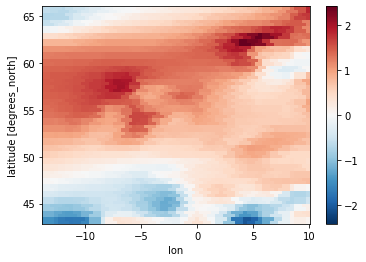

In [33]:
ds_regridded.mean(['member','exp','time']).plot()